In [1]:
from matplotlib import pyplot as plt
plt.style.use('bmh')
%matplotlib inline

import numpy as np
from astropy import units as u
from astropy.utils import console

from piaa import observation
from astropy.io import fits

### Gather images

We examine both cameras on a new moon night. Sensor properties of the EOS100D are set, which are used for the calculations below in order to determine minimum exposure times needed to reach the photon-noise limit.

In [2]:
dirs = {
    'Camera 01': '/var/panoptes/images/fields/HatP20/14d3bd/20170128T053449/',
    'Camera 02': '/var/panoptes/images/fields/HatP20/ee04d1/20170128T053449/',        
}

# Sensor properties
gain = 1.696 * (u.electron / u.adu)

readout_noise_e = 11.5 * (u.electron)
readout_noise_adu = readout_noise_e / gain

# We want photon noise >= readout noise (in electrons). That minimum is:
photon_noise_equal_read_noise = ((readout_noise_e.value**2) * u.electron / gain)

## Calculate backgrounds

Loop through each of the cameras and determine the background levels for each channel separately.

In [4]:
moon_lookup = {
    'Camera 01': '--',
    'Camera 02': '-'
}

bkg_image = {}

for moon, directory in dirs.items():
    obs = observation.Observation(directory)

    bkg_image[moon] = obs.get_frame_background(1, background_obj=True)

    for frame_index in console.ProgressBar(range(len(obs.files) ), ipython_widget=True):
        obs.get_frame_background(frame_index, summary=True)

## Plot the backgrounds

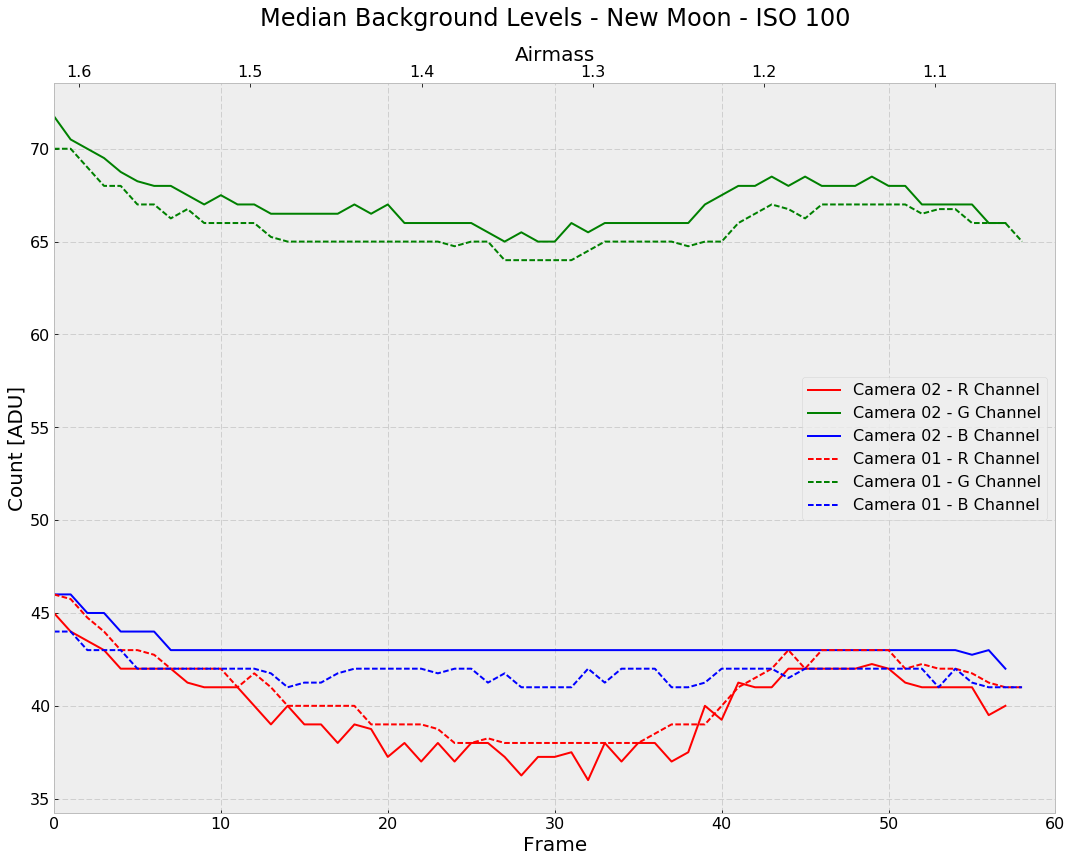

In [10]:
plt.figure(figsize=(15,12))

moon_lookup = {
    'Camera 01': '--',
    'Camera 02': '-'
}

bkg_image = {}

for moon, directory in dirs.items():
    obs = observation.Observation(directory)

    background_data = np.array(obs.hdf5['background'])

    plt.plot(background_data[2:, 0, 0], 'r', ls=moon_lookup[moon], label='{} - R Channel'.format(moon))
    plt.plot(background_data[2:, 1, 0], 'g', ls=moon_lookup[moon], label='{} - G Channel'.format(moon))
    plt.plot(background_data[2:, 2, 0], 'b', ls=moon_lookup[moon], label='{} - B Channel'.format(moon))

# Title, legend, labels
plt.title("Median Background Levels - New Moon - ISO 100", fontsize=24, y=1.07)
plt.legend(fontsize=16)
plt.xlabel('Frame', fontsize=20)
plt.ylabel('Count [ADU]', fontsize=20)
plt.xlim(0, len(obs.files) - 1)

a = plt.gca()
a.set_xticklabels([int(i) for i in a.get_xticks()], {'size': 16})
a.set_yticklabels([int(i) for i in a.get_yticks()], {'size': 16})

# Get airmasses and create second x-axis
am = [obs.get_header_value(i, 'AIRMASS') for i in range(1, len(obs.files))]
b = a.twiny()
b.set_xlim(am[0], am[-1])
b.set_xticklabels(b.get_xticks(), {'size': 16})
b.grid(False)
b.set_xlabel('Airmass', fontsize=20)

plt.tight_layout()
plt.savefig('background_counts.png', dpi=300)

## Determine exposure times for photon-noise limited performance

In [11]:
minimum_counts_per_pixsec = None

rgb_lookup = {
    'R': 0,
    'G': 1,
    'B': 2,
}

frame_index = 1

print("Gain:       {}".format(gain))
print("RN:         {:.02f}".format(readout_noise_e))
print("RN:         {:.02f}".format(readout_noise_adu))
print("RN = PN:    {:.02f}".format(photon_noise_equal_read_noise))
print("")

exp_time = obs.get_header_value(frame_index, 'EXPTIME') * u.second
print("Exp time:   {}".format(exp_time))

iso = obs.get_header_value(frame_index, 'ISO')
print("ISO:        {}".format(iso))

moon_fraction = obs.get_header_value(frame_index, 'MOONFRAC')
print("Moon phase: {:.02f}".format(moon_fraction))
print("")

for channel in ['R', 'G', 'B']:
    print("{} channel:".format(channel))
    
    mom = background_data[2:, rgb_lookup[channel], 0].mean()
    morms = background_data[2:, rgb_lookup[channel], 1].mean()

    print("\tMean of Median:      {:.02f}".format(mom))
    print("\tMean of RMS Median:  {:.02f}".format(morms))
    counts_per_pixsec = (mom / exp_time) * u.adu
    if minimum_counts_per_pixsec is None or counts_per_pixsec < minimum_counts_per_pixsec:
        minimum_counts_per_pixsec = counts_per_pixsec
    print("\tMedian per Pixel:    {:.02f}".format(counts_per_pixsec))
    print("\tMedian per Pixel:    {:.02f}".format(counts_per_pixsec * gain))
    print("")
    
# We want the minimum counts (given by the blue) to be greater than min_electrons. To do this, we need to expose for
min_exp_time = photon_noise_equal_read_noise / (minimum_counts_per_pixsec)
print("Minimum exposure time for photon-noise limited: {:.02f}".format(min_exp_time))

Gain:       1.696 electron / adu
RN:         11.50 electron
RN:         6.78 adu
RN = PN:    77.98 adu

Exp time:   120.1 s
ISO:        100
Moon phase: 0.00

R channel:
	Mean of Median:      40.77
	Mean of RMS Median:  11.15
	Median per Pixel:    0.34 adu / s
	Median per Pixel:    0.58 electron / s

G channel:
	Mean of Median:      65.89
	Mean of RMS Median:  12.61
	Median per Pixel:    0.55 adu / s
	Median per Pixel:    0.93 electron / s

B channel:
	Mean of Median:      41.83
	Mean of RMS Median:  11.57
	Median per Pixel:    0.35 adu / s
	Median per Pixel:    0.59 electron / s

Minimum exposure time for photon-noise limited: 229.72 s
